## From the Authors

SAMSum Dataset


```
@inproceedings{gliwa-etal-2019-samsum,
    title = "{SAMS}um Corpus: A Human-annotated Dialogue Dataset for Abstractive Summarization",
    author = "Gliwa, Bogdan  and
      Mochol, Iwona  and
      Biesek, Maciej  and
      Wawer, Aleksander",
    booktitle = "Proceedings of the 2nd Workshop on New Frontiers in Summarization",
    month = nov,
    year = "2019",
    address = "Hong Kong, China",
    publisher = "Association for Computational Linguistics",
    url = "https://www.aclweb.org/anthology/D19-5409",
    doi = "10.18653/v1/D19-5409",
    pages = "70--79"
}

```

In [48]:
import os
import json

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
import plotly.graph_objs as go

from scipy import stats

import torch
from transformers import PegasusForConditionalGeneration, PegasusTokenizer
from transformers import BartForConditionalGeneration, BartTokenizer
from transformers import T5ForConditionalGeneration, T5Tokenizer
from transformers import AutoModelForMaskedLM, get_cosine_schedule_with_warmup
from torch.utils.data import DataLoader
from torch.optim.lr_scheduler import LambdaLR
import pytorch_lightning as pl

from torch.utils.data.dataset import TensorDataset, random_split

data comes in as neatly formatted JSON

In [66]:
val_path = '../data/raw/val.json'
test_path = '../data/raw/test.json'
train_path = '../data/raw/train.json'

with open(val_path) as in_file:
    val = json.load(in_file)
    in_file.close()
    
with open(test_path) as in_file:
    test = json.load(in_file)
    in_file.close()
    
with open(train_path) as in_file:
    train = json.load(in_file)
    in_file.close()
    
data = train + test + val
assert len(data) == len(train) + len(test) + len(val)

df = pd.DataFrame(data)
df['dialogue'] = df['dialogue'].str.replace('\r', '')
df['dialogue'] = df['dialogue'].str.replace('\n', ' ')
df['summary'] = df['summary'].str.replace('\r', '')
df['summary'] = df['summary'].str.replace('\n', ' ')
df.head()

,id,summary,dialogue
0,13818513,Amanda baked cookies and will bring Jerry some...,Amanda: I baked cookies. Do you want some? Je...
1,13728867,Olivia and Olivier are voting for liberals in ...,Olivia: Who are you voting for in this electio...
2,13681000,Kim may try the pomodoro technique recommended...,"Tim: Hi, what's up? Kim: Bad mood tbh, I was g..."
3,13730747,Edward thinks he is in love with Bella. Rachel...,"Edward: Rachel, I think I'm in ove with Bella...."
4,13728094,"Sam is confused, because he overheard Rick com...",Sam: hey overheard rick say something Sam: i ...


combine them all into one dataset for eda

cleaning up some separator characters (\n and \r) from our dialogue section

In [68]:
t5_tokenizer.max_len

/Users/zbloss/Library/Python/3.8/lib/python/site-packages/transformers/tokenization_utils_base.py:1319: FutureWarning: The `max_len` attribute has been deprecated and will be removed in a future version, use `model_max_length` instead.
  warnings.warn(


512

# T5

In [21]:
from transformers import T5Tokenizer

t5_tokenizer = T5Tokenizer.from_pretrained('t5-small')

In [22]:
t5_df = df.sample(1000)

In [23]:
t5_df['summary_len'] = t5_df['summary'].str.split().apply(len)
t5_df['dialogue_len'] = t5_df['dialogue'].str.split().apply(len)

In [24]:
t5_df = t5_df[t5_df['summary_len'] < t5_df['dialogue_len']]

In [74]:
dialogue = t5_df['dialogue'].values.tolist()
summary = t5_df['summary'].values.tolist()

data = t5_tokenizer.prepare_seq2seq_batch(
    src_texts=[f'summarize: {d}' for d in dialogue], 
    tgt_texts=summary, 
    padding='max_length', 
    truncation=True, 
    return_tensors='pt'
)

torch.Size([997, 512])

In [72]:
type(data)

transformers.tokenization_utils_base.BatchEncoding

In [41]:
data.keys()

dict_keys(['input_ids', 'attention_mask', 'labels'])

In [43]:
from torch.utils.data import TensorDataset

tdata = TensorDataset(
    data['input_ids'], 
    data['attention_mask'], 
    data['labels']
)

In [45]:
import torch
from torch.utils.data import random_split

train_size = int(data['input_ids'].shape[0] * 0.80)
test_size = int(data['input_ids'].shape[0] * 0.10)
val_size = int(data['input_ids'].shape[0]) - train_size - test_size

assert train_size + test_size + val_size == int(data['input_ids'].shape[0])

train, test, val = random_split(dataset=tdata, lengths=(train_size, test_size, val_size))

torch.save(train, '../data/processed/t5_train_dataset.pt')
torch.save(test, '../data/processed/t5_test_dataset.pt')
torch.save(val, '../data/processed/t5_val_dataset.pt')

In [57]:
train_size + test_size + val_size

997

In [49]:
class T5LightningModule(pl.LightningModule):
    def __init__(
        self,
        pretrained_nlp_model: str,
        train_dataset: str,
        test_dataset: str,
        val_dataset: str,
        batch_size: int,
        learning_rate: float = 3e-05,
    ):
        """
        A Pytorch-Lightning Module that trains Bart from the  HuggingFace transformers
        library.

        :param pretrained_nlp_model: (str) the name of the pretrained mode you want to use.
        :param train_dataset: (str) path to pytorch dataset containing train data.
        :param test_dataset: (str) path to pytorch dataset containing test data.
        :param val_dataset: (str) path to pytorch dataset containing validation data.
        :param batch_size: (int) Number of data points to pass per batch in the train, test, and validation sets.
        :param learning_rate: (float) Initial Learning Rate to set.
        :returns: None
        """
        super().__init__()

        self.batch_size = int(batch_size)
        self.train_dataset = str(train_dataset)
        self.test_dataset = str(test_dataset)
        self.val_dataset = str(val_dataset)
        self.hparams.learning_rate = learning_rate
        
        self.t5 = T5ForConditionalGeneration.from_pretrained(pretrained_nlp_model)
        self.tokenizer = T5Tokenizer.from_pretrained(pretrained_nlp_model)
        
        
    def forward(self, x):
        
        # Run through NLP Model
        output = self.t5(**x)
        return output

    def training_step(self, batch, batch_idx):

        input_ids, attn_mask, labels = batch

        x = {
            "input_ids": input_ids,
            "attention_mask": attn_mask,
            "labels": labels,
            "return_dict": True,
        }

        # Run through NLP Model
        out = self.t5(**x)

        loss = out["loss"]
        print(f"current_epoch: {self.current_epoch};")
        print(f"global_step: {self.global_step};")
        print(f"train_loss: {loss};")
        print(f"learning_rate: {self.hparams.learning_rate};")

        
        self.log("train_loss", loss, on_step=False, on_epoch=True, logger=True)
        return loss

    def validation_step(self, batch, batch_idx):
        input_ids, attn_mask, labels = batch

        x = {
            "input_ids": input_ids,
            "attention_mask": attn_mask,
            "labels": labels,
            "return_dict": True,
        }

        # Run through NLP Model
        out = self.t5(**x)
        loss = out["loss"]
        
        
        print(f"val_loss: {loss};")
        self.log("val_loss", loss, on_step=False, on_epoch=True, logger=True)

        # Generating Example Summary
        if batch_idx == len(self.val_dataloader())-1:
            
            outputs = self.t5.generate(inputs['input_ids'])
            predictions = self.tokenizer.batch_decode(
                outputs, 
                skip_special_tokens=True, 
                clean_up_tokenization_spaces=True
            )
            
            references = self.tokenizer.batch_decode(
                labels, skip_special_tokens=True, clean_up_tokenization_spaces=True
            )
            for idx, pred in enumerate(predictions):
                
                self.logger.experiment.add_text(
                    tag='example_summaries',
                    text_string=f'''
                    Model Summary: {predictions[idx]}
                
                    Target Summary: {references[idx]}''',
                    global_step=self.global_step,
                )

        return loss
        

    def test_step(self, batch, batch_idx):
        input_ids, attn_mask, labels = batch

        x = {
            "input_ids": input_ids,
            "attention_mask": attn_mask,
            "labels": labels,
            "return_dict": True,
        }

        # Run through NLP Model
        out = self.t5(**x)

        loss = out["loss"]
        print(f"test_loss: {loss};")

        self.log("test_loss", loss, on_step=False, on_epoch=True, logger=True) 

        return loss

    def configure_optimizers(self):
        """
        Recreating the same Adam optimizer used in the author's code.
        """

        optimizer = torch.optim.Adam(
            self.parameters(),
            lr=self.hparams.learning_rate,
            weight_decay=0.01,
            betas=(0.9, 0.999),
            eps=1e-08,
        )
        
        scheduler = get_cosine_schedule_with_warmup(optimizer, num_warmup_steps=500, num_training_steps=20000)
        print(f'scheduler: {scheduler}')
        gen_sched = {'scheduler': scheduler, 'interval': 'step'}
        
        return [optimizer], [gen_sched]
    
        
    def train_dataloader(self):
        return DataLoader(
            torch.load(self.train_dataset), shuffle=True, batch_size=self.batch_size
        )

    def val_dataloader(self):
        return DataLoader(
            torch.load(self.val_dataset), shuffle=False, batch_size=self.batch_size
        )

    def test_dataloader(self):
        return DataLoader(
            torch.load(self.test_dataset), shuffle=True, batch_size=self.batch_size
        )


In [52]:
model = T5LightningModule(
    train_dataset='../data/processed/t5_train_dataset.pt',
    test_dataset='../data/processed/t5_test_dataset.pt',
    val_dataset='../data/processed/t5_val_dataset.pt',
    pretrained_nlp_model='t5-small',
    batch_size=4,
    learning_rate=3e-05,
)

In [51]:
trainer_params = {
    "max_epochs": 3,
    "default_root_dir": '../models/t5',
    "gpus": 0,
    #"logger": tb_logger,
    #"early_stop_callback": early_stop,
    #"checkpoint_callback": model_checkpoint,
    #"callbacks": [lr_logger],
    #"precision": 16,
    'fast_dev_run': False
}

print(f"Trainer Params: {trainer_params}")

trainer = pl.Trainer(**trainer_params)
trainer.fit(model)

GPU available: False, used: False
TPU available: False, using: 0 TPU cores

  | Name | Type                       | Params
----------------------------------------------------
0 | t5   | T5ForConditionalGeneration | 60 M  


Trainer Params: {'max_epochs': 3, 'default_root_dir': '../models/t5', 'gpus': 0, 'fast_dev_run': False}
scheduler: <torch.optim.lr_scheduler.LambdaLR object at 0x1686c2160>


/Users/zbloss/Library/Python/3.8/lib/python/site-packages/pytorch_lightning/utilities/distributed.py:45: UserWarning: The dataloader, val dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  warnings.warn(*args, **kwargs)


val_loss: 11.663716316223145;
val_loss: 9.932066917419434;


/Users/zbloss/Library/Python/3.8/lib/python/site-packages/pytorch_lightning/utilities/distributed.py:45: UserWarning: The dataloader, train dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  warnings.warn(*args, **kwargs)


current_epoch: 0;
global_step: 0;
train_loss: 11.469995498657227;
learning_rate: 3e-05;
current_epoch: 0;
global_step: 1;
train_loss: 9.353856086730957;
learning_rate: 3e-05;
current_epoch: 0;
global_step: 2;
train_loss: 9.287805557250977;
learning_rate: 3e-05;


/Users/zbloss/Library/Python/3.8/lib/python/site-packages/pytorch_lightning/utilities/distributed.py:45: UserWarning: Detected KeyboardInterrupt, attempting graceful shutdown...
  warnings.warn(*args, **kwargs)
/Users/zbloss/Library/Python/3.8/lib/python/site-packages/torch/optim/lr_scheduler.py:200: UserWarning: Please also save or load the state of the optimzer when saving or loading the scheduler.
  warnings.warn(SAVE_STATE_WARNING, UserWarning)


KeyboardInterrupt: 

In [55]:
model.load_state_dict(torch.load('../models/t5/epoch=20.ckpt', map_location=torch.device('cpu'))['state_dict'])

<All keys matched successfully>

In [ ]:
tokenizer = BartTokenizer.from_pretrained('sshleifer/distilbart-cnn-12-6')

tokenizing the text to get an idea of how long the dialogue and summaries are

In [242]:
dialogue = df['dialogue'].values.tolist()
summary = df['summary'].values.tolist()

In [243]:
dialogue_tokens = t5_tokenizer.prepare_seq2seq_batch(dialogue, padding='longest', truncation=False, return_tensors='np')

In [244]:
summary_tokens = t5_tokenizer.prepare_seq2seq_batch(summary, padding='longest', truncation=False, return_tensors='np')

In [245]:
num_dialogues, longest_dialogue = dialogue_tokens['input_ids'].shape

In [246]:
num_summaries, longest_summary = summary_tokens['input_ids'].shape

In [247]:
assert num_dialogues == num_summaries

In [248]:
print(f'The longest dialogue is: {longest_dialogue}\n')
print(f'The longest summary is: {longest_summary}')

The longest dialogue is: 4451

The longest summary is: 90


Doing so gives us an attention mask, which easily highlights where the padding begins.

The attention mask contains 1's where there was no padding, and 0's where there was padding.

So we can sum the attention mask to see how many tokens are in each dialogue of our dataset

In [249]:
stats.describe(np.sum(dialogue_tokens['attention_mask'], axis=1))

DescribeResult(nobs=16369, minmax=(2, 4451), mean=149.80884598937016, variance=12817.899980394717, skewness=4.65691616855521, kurtosis=129.46748943477988)

The model that we are going to use in this project can handle 1,024 tokens by default. It appears that almost all of our dialogue tokens are below 1000 tokens, however we have a couple of outliers.

To keep things simple, we will reapply the tokenizer, but this time Truncating our data to 1,024 tokens. Another alternative to this would be to drop the examples that contain more than 1,024 tokens.

In [250]:
over_1024 = np.count_nonzero(np.sum(dialogue_tokens['attention_mask'], axis=1) > 1024)
at_or_below_1024 = np.count_nonzero(np.sum(dialogue_tokens['attention_mask'], axis=1) <= 1024)

print(f'Samples above 1024: {over_1024}')
print(f'At or below 1024: {at_or_below_1024}')

Samples above 1024: 2
At or below 1024: 16367


In [251]:
print(f'% of our data above the 1,024 limit: {round((100*(over_1024 / (over_1024+at_or_below_1024))), 4)}%')

% of our data above the 1,024 limit: 0.0122%


In [252]:
dialogue_lens = np.sum(dialogue_tokens['attention_mask'], axis=1)
summary_lens = np.sum(summary_tokens['attention_mask'], axis=1)

/Users/zbloss/Library/Python/3.8/lib/python/site-packages/seaborn/distributions.py:2551: FutureWarning:

`distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).



Text(0.5, 1.0, 'Dialogue Lengths (Tokens)')

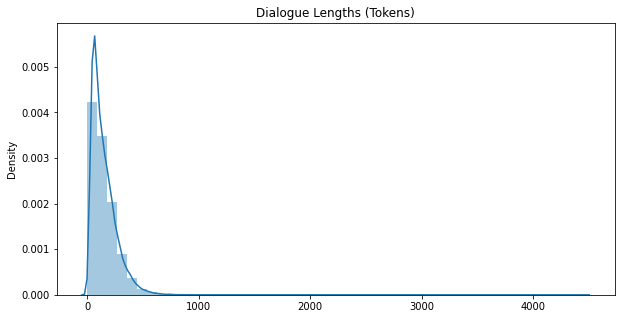

In [253]:
plt.figure(figsize=(10, 5))
sns.distplot(dialogue_lens)
plt.title('Dialogue Lengths (Tokens)')

/Users/zbloss/Library/Python/3.8/lib/python/site-packages/seaborn/distributions.py:2551: FutureWarning:

`distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).



Text(0.5, 1.0, 'Summary Lengths (Tokens)')

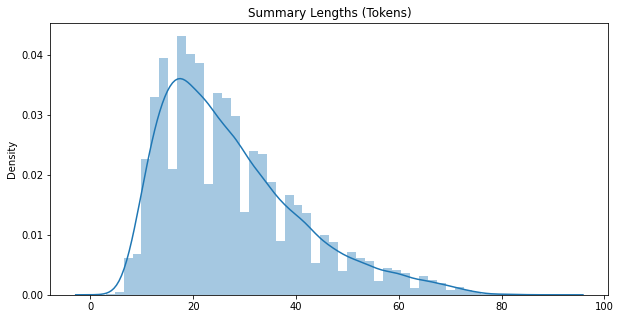

In [254]:
plt.figure(figsize=(10, 5))
sns.distplot(summary_lens)
plt.title('Summary Lengths (Tokens)')

# Retokenizing with Truncation

In [255]:
dialogue_tokens = tokenizer.prepare_seq2seq_batch(dialogue, padding='longest', truncation=True, return_tensors='np')

In [256]:
summary_tokens = tokenizer.prepare_seq2seq_batch(summary, padding='longest', truncation=True, return_tensors='np')

In [257]:
dialogue_lens = np.sum(dialogue_tokens['attention_mask'], axis=1)
summary_lens = np.sum(summary_tokens['attention_mask'], axis=1)

/Users/zbloss/Library/Python/3.8/lib/python/site-packages/seaborn/distributions.py:2551: FutureWarning:

`distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).



Text(0.5, 1.0, 'Dialogue Lengths (Truncated Tokens)')

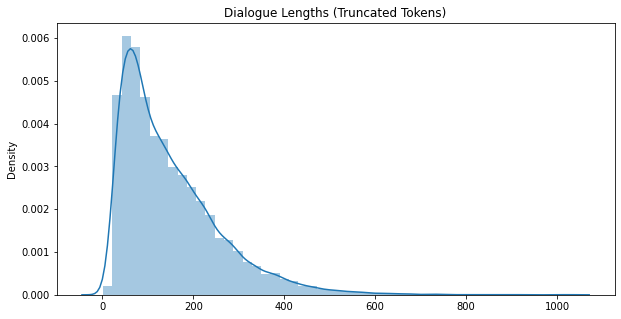

In [258]:
plt.figure(figsize=(10, 5))
sns.distplot(dialogue_lens)
plt.title('Dialogue Lengths (Truncated Tokens)')

/Users/zbloss/Library/Python/3.8/lib/python/site-packages/seaborn/distributions.py:2551: FutureWarning:

`distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).



Text(0.5, 1.0, 'Summary Lengths (Truncated Tokens)')

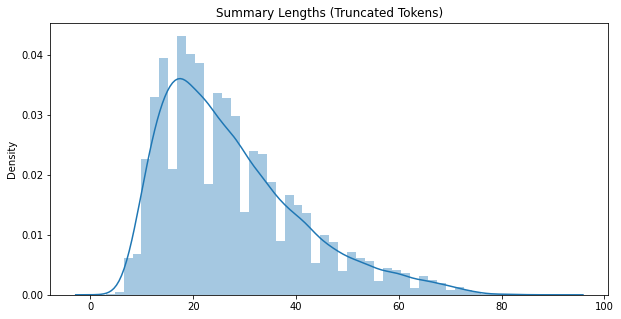

In [259]:
plt.figure(figsize=(10, 5))
sns.distplot(summary_lens)
plt.title('Summary Lengths (Truncated Tokens)')

Examine ratios from summary to dialogue

In [260]:
ratio = summary_lens / dialogue_lens

/Users/zbloss/Library/Python/3.8/lib/python/site-packages/seaborn/distributions.py:2551: FutureWarning:

`distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).



Text(0.5, 1.0, 'Summary:Dialogue Ratio')

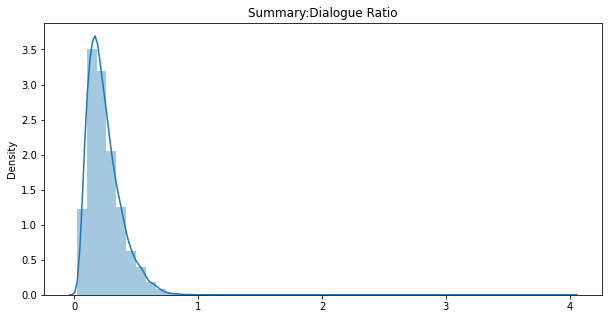

In [261]:
plt.figure(figsize=(10, 5))
sns.distplot(ratio)
plt.title('Summary:Dialogue Ratio')

It appears we have two sticklers where the summary is actually longer than the dialogue?

So we will remove these

In [262]:
data = np.array(data)[ratio < 1]

In [263]:
df = pd.DataFrame(data)
dialogue_tokens = tokenizer.prepare_seq2seq_batch(dialogue, padding='longest', truncation=True, return_tensors='np')
summary_tokens = tokenizer.prepare_seq2seq_batch(summary, padding='longest', truncation=True, return_tensors='np')

In [264]:
dialogue_lens = np.sum(dialogue_tokens['attention_mask'], axis=1)
summary_lens = np.sum(summary_tokens['attention_mask'], axis=1)

In [265]:
df.count()

0    16367
dtype: int64

## Rebuilding plots

/Users/zbloss/Library/Python/3.8/lib/python/site-packages/seaborn/distributions.py:2551: FutureWarning:

`distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).



Text(0.5, 1.0, 'Dialogue Lengths (Truncated Tokens)')

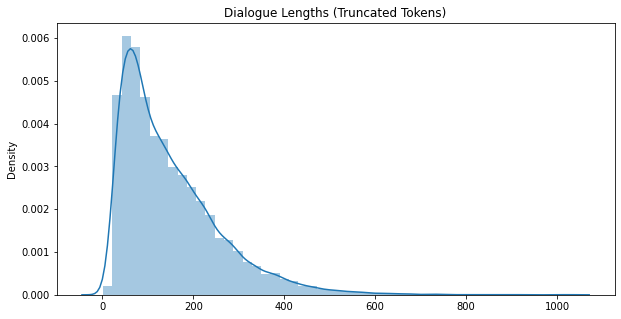

In [266]:
plt.figure(figsize=(10, 5))
sns.distplot(dialogue_lens)
plt.title('Dialogue Lengths (Truncated Tokens)')

/Users/zbloss/Library/Python/3.8/lib/python/site-packages/seaborn/distributions.py:2551: FutureWarning:

`distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).



Text(0.5, 1.0, 'Summary Lengths (Truncated Tokens)')

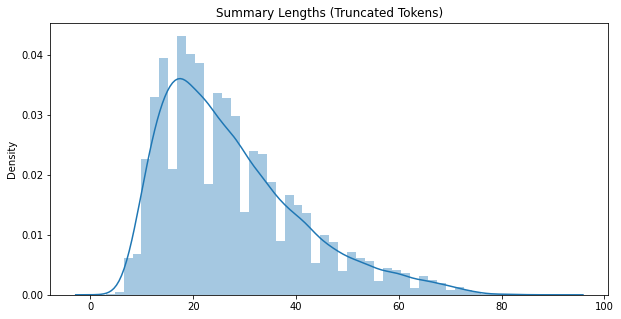

In [267]:
plt.figure(figsize=(10, 5))
sns.distplot(summary_lens)
plt.title('Summary Lengths (Truncated Tokens)')

/Users/zbloss/Library/Python/3.8/lib/python/site-packages/seaborn/distributions.py:2551: FutureWarning:

`distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).



Text(0.5, 1.0, 'Summary:Dialogue Ratio')

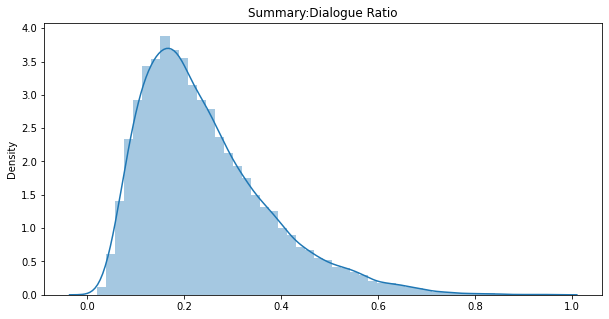

In [268]:
plt.figure(figsize=(10, 5))
sns.distplot(ratio[ratio <= 1])
plt.title('Summary:Dialogue Ratio')

In [269]:
stats.describe(ratio[ratio<=1])

DescribeResult(nobs=16367, minmax=(0.020249221183800622, 0.9523809523809523), mean=0.24314725531051332, variance=0.01748397896582523, skewness=1.1182504101585526, kurtosis=1.3756931893566717)

# Modeling

In [270]:
model = BartForConditionalGeneration.from_pretrained('sshleifer/distilbart-cnn-12-6')

In [271]:
batch = tokenizer.prepare_seq2seq_batch([dialogue[0]], truncation=True, padding='longest', return_tensors='pt')
translated = model.generate(**batch)

In [272]:
dialogue[0]

"Amanda: I baked  cookies. Do you want some?\nJerry: Sure!\nAmanda: I'll bring you tomorrow :-)"

In [276]:
tokenizer.batch_decode(translated, skip_special_tokens=True)

[' Amanda: I baked  cookies. Do you want some?Jerry: Sure! Amanda: "I\'ll bring you tomorrow :-) I\'ll bring them tomorrow :-) Jerry: "Sure! I baked cookies. You want some?" Jerry: Sure, I bake cookies. Amanda: "Do you want  cookies?" Jerry asks Amanda.']

In [281]:
idx = 1

batch = tokenizer.prepare_seq2seq_batch(dialogue[idx], truncation=True, padding='longest', return_tensors='pt')
translated = model.generate(**batch)

print(f'dialogue:\n{dialogue[idx]}\n')
print(f'summary:\n{summary[idx]}\n')
print('--------------------------')
print(f'model summary:\n{tokenizer.batch_decode(translated, skip_special_tokens=True)[0]}')

dialogue:
Olivia: Who are you voting for in this election? 
Oliver: Liberals as always.
Olivia: Me too!!
Oliver: Great

summary:
Olivia and Olivier are voting for liberals in this election. 

--------------------------
model summary:
 Oliver says he is voting for the Liberal Party in the upcoming election. Oliver: Liberals as always. Liberal as always. Olivier: Me too!! Oliver says. Olivier says he's voting for Hillary Clinton. Oliver says she's voting in the next election. She says she'll be voting for Obama.


# Preprocessing

In [284]:
import torch
from torch.utils.data.dataset import TensorDataset, random_split

In [8]:
dialogue_lens = np.sum(dialogue_tokens['attention_mask'], axis=1)
summary_lens = np.sum(summary_tokens['attention_mask'], axis=1)

assert len(dialogue_lens) == len(summary_lens)

NameError: name 'dialogue_tokens' is not defined

In [ ]:
dialogue_tokens = tokenizer.prepare_seq2seq_batch(dialogue, padding='longest', truncation=True, return_tensors='pt')
summary_tokens = tokenizer.prepare_seq2seq_batch(summary, padding='longest', truncation=True, return_tensors='pt')

In [ ]:
dialogue_tokens

In [298]:
td = {
    'input_ids': dialogue_tokens['input_ids'],
    'attention_mask': dialogue_tokens['attention_mask'],
    'label_ids': summary_tokens['input_ids']
}

In [310]:
train_size = int(dialogue_tokens['input_ids'].shape[0] * 0.80)
test_size = int(dialogue_tokens['input_ids'].shape[0] * 0.10)
val_size = int(dialogue_tokens['input_ids'].shape[0]) - train_size - test_size

assert train_size + test_size + val_size == int(dialogue_tokens['input_ids'].shape[0])

In [304]:
td = TensorDataset(dialogue_tokens['input_ids'], dialogue_tokens['attention_mask'], summary_tokens['input_ids'])

In [307]:
for step, batch in enumerate(td):
    print(step)
    feature, mask, label = batch
    print(f'feature: {feature}\n\n\n')
    print(f'mask: {mask}\n\n\n')
    print(f'label: {label}\n\n\n')
    break

0
feature: tensor([    0, 10127,  5219,  ...,     1,     1,     1])



mask: tensor([1, 1, 1,  ..., 0, 0, 0])



label: tensor([    0, 10127,  5219, 17241, 15269,     8,    40,   836,  6509,   103,
         3859,     4,     2,     1,     1,     1,     1,     1,     1,     1,
            1,     1,     1,     1,     1,     1,     1,     1,     1,     1,
            1,     1,     1,     1,     1,     1,     1,     1,     1,     1,
            1,     1,     1,     1,     1,     1,     1,     1,     1,     1,
            1,     1,     1,     1,     1,     1,     1,     1,     1,     1,
            1,     1,     1,     1,     1,     1,     1,     1,     1,     1,
            1,     1,     1,     1,     1,     1,     1,     1,     1,     1,
            1,     1,     1,     1,     1,     1,     1,     1,     1,     1])





In [312]:
train, test, val = random_split(dataset=td, lengths=(train_size, test_size, val_size))

# Finished Preprocessing

## Begin Model Experimentation

In [9]:
model = BartForConditionalGeneration.from_pretrained('sshleifer/distilbart-cnn-12-6')
tokenizer = BartTokenizer.from_pretrained('sshleifer/distilbart-cnn-12-6')

In [2]:
val = torch.load('../data/processed/val_dataset.pt')

In [ ]:
self.example_input_array